# Intelligent Systems 2020 - I - Final Project - QR detector - YOLOv3

Here are described the four main steps taken to accomplish this project:
1. Data analysis and preprocessing
2. Model development
3. Models evaluation
4. Testing in additional testing set.

Project done by:
- Nicolás Restrepo Torres - nrestrepot@unal.edu.co
- Cristian David González Carrillo - crdgonzalezca@unal.edu.co

[Report QR classificator](https://www.overleaf.com/7856659368vmnrgbtchgrg)

## 1. Data analysis and preprocessing

### 1.1 Dataset preparation

We have created a [repository](https://github.com/crdgonzalezca/QR-codes-detection.git) which contains several configurations for the model and the already label dataset. 
The dataset was labeled using _'LabelImg'_. This dataset is in the folder `dataset` where every image has its annotations in a .txt file. The format of each label is yolo: 

`<class_id> <center_x> <center_y> <width> <height>`

#### 1.1.1. Clone repository

Run this cell only once. 

In [1]:
!git clone https://github.com/crdgonzalezca/QR-codes-detection.git /content/repo/
%cd /content/repo

Cloning into '/content/repo'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 573 (delta 2), reused 6 (delta 2), pack-reused 567
Receiving objects: 100% (573/573), 377.17 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (441/441), done.
/content/repo


#### 1.1.2. Import necessary python modules and custom utilities

The script `utils.py` is in the repository which contains some custom utilities to process the data and other funtions

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(1, '/content/repo/')
from utils import generate_annotations_df, split_dataset, load_annotations, generate_csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 1.1.3. Load the annotations and dataset
This receives a parameter `use_negatives`. We have also created a dataset of images that not contain QR codes to test whether Average Precision increases or not when the model is trained with it.

In [228]:
annotations = load_annotations(use_negatives=False, use_augmentation=False)

Loaded 0 negative images, 0 augmentation images, 96 images and 225 annotations.


#### 1.1.4. Split dataset

Split the total dataset into training and validation sets. By default we split as $70\%$ training, $20\%$ validation and $10\%$ testing.

In [229]:
data = list(annotations.keys())
train_data, val_data, test_data = split_dataset(data, val_split=0.2, test_split=0.1)
print(f'Training data (70%): {len(train_data)} images, validation (20%): {len(val_data)} images and testing (10%): {len(test_data)} images')

Training data (70%): 68 images, validation (20%): 19 images and testing (10%): 9 images


#### 1.1.5. Load dataset as Dataframe (Optional)

This takes every image and its annotations and creates the next Dataframe. 
As annotations are normalized between 0 and 1, they are denormalized.

In [232]:
annotations_df = generate_annotations_df(annotations)
annotations_df.describe(include='all')

,image_name,x,y,width,height
count,225,225.000000,225.000000,225.000000,225.000000
unique,96,NaN,NaN,NaN,NaN
top,IMG_2763.JPG,NaN,NaN,NaN,NaN
freq,14,NaN,NaN,NaN,NaN
mean,NaN,1301.226667,2061.844444,460.484444,921.106667
std,NaN,668.452803,1036.174079,343.328548,633.781598
min,NaN,109.000000,196.000000,15.000000,90.000000
25%,NaN,741.000000,1294.000000,232.000000,500.000000
50%,NaN,1244.000000,1823.000000,335.000000,725.000000
75%,NaN,1703.000000,2853.000000,648.000000,1239.000000


In [233]:
# Generate CSV
generate_csv(annotations_df, 'dataset.csv', [set(map(lambda x: x.split('/')[-1], train_data)), set(map(lambda x: x.split('/')[-1], val_data)), set(map(lambda x: x.split('/')[-1], test_data))])

### 1.2. Dataset analysis

#### 1.2.1. Generate DataFrame

This Dataframe contains the `width` and `height` for every image.

There's a total of **96 images** in the dataset.

In [ ]:
from utils import load_images_sizes
list_images = annotations.keys()
images_df = load_images_sizes(list_images)
images_df.describe(include='all')

,image,width,height
count,96,96.000000,96.000000
unique,96,NaN,NaN
top,/content/repo/dataset/IMG_20120226_151917.jpg,NaN,NaN
freq,1,NaN,NaN
mean,NaN,2470.250000,3631.166667
std,NaN,863.959612,1275.567314
min,NaN,768.000000,768.000000
25%,NaN,1440.000000,2560.000000
50%,NaN,3168.000000,4752.000000
75%,NaN,3168.000000,4752.000000


#### 1.2.2. Images size distribution

In [ ]:
 sns.set(style="white", color_codes=True)

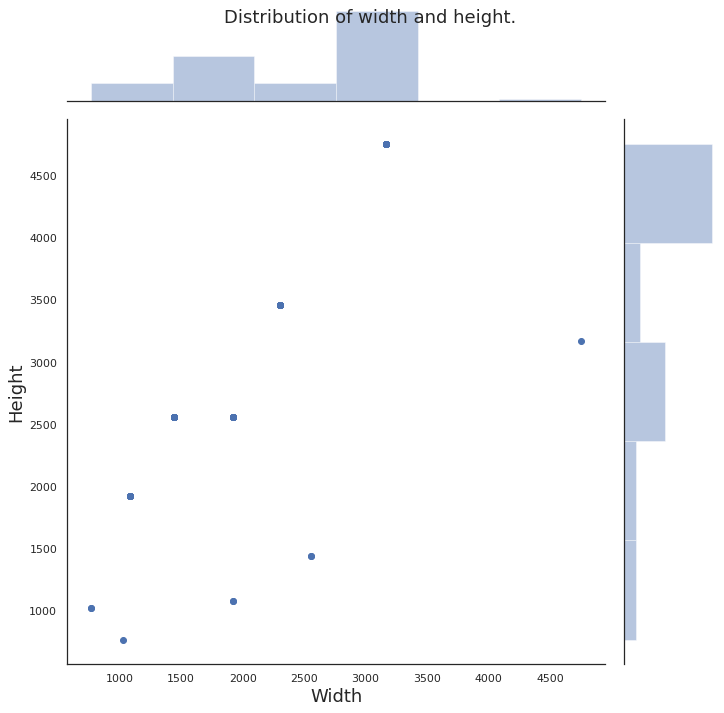

In [ ]:
joint_plot = sns.jointplot(x='width', y='height', data=images_df, height=10, kind='scatter')
joint_plot.set_axis_labels('Width', 'Height', fontsize=18)
fig = joint_plot.fig
fig.suptitle('Distribution of width and height.', fontsize=18)
fig.set_size_inches((10, 10))
fig.savefig('/content/repo/assets/scatter_plot_images.png', dpi=200)

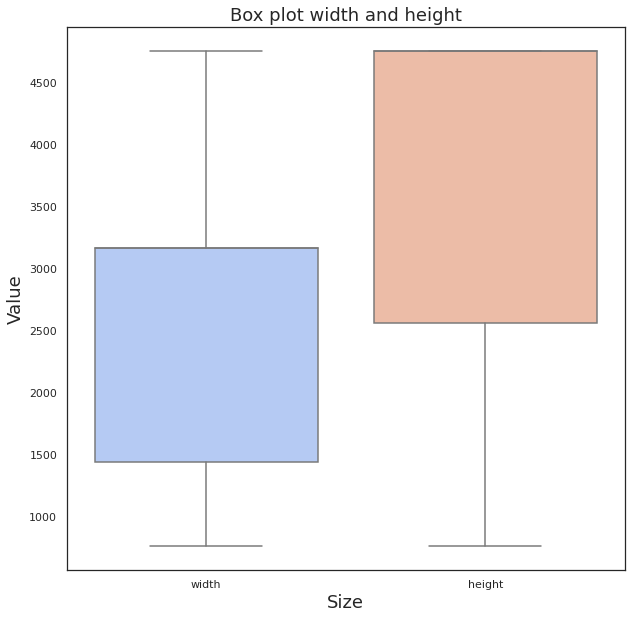

In [ ]:
box_plot = sns.boxplot(data=images_df, palette='coolwarm')
box_plot.set_title("Box plot width and height", fontsize=18)
box_plot.set_xlabel("Size", fontsize=18)
box_plot.set_ylabel("Value", fontsize=18)
fig = box_plot.get_figure()
fig.set_size_inches((10, 10))
fig.savefig('/content/repo/assets/box_plot_images.png', dpi=200)

#### 1.2.3. Annotations (Boxes) size distribution

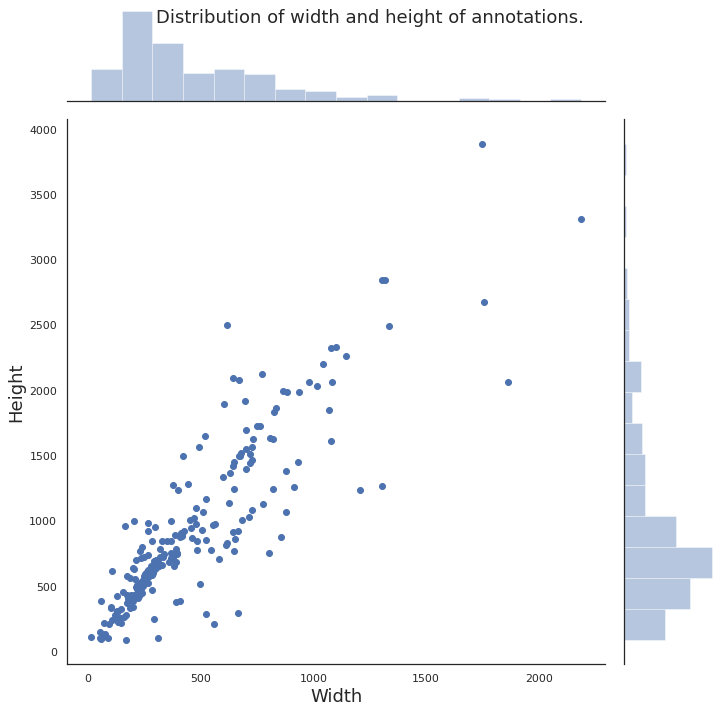

In [ ]:
joint_plot = sns.jointplot(x='width', y='height', data=annotations_df, height=10, kind='scatter')
joint_plot.set_axis_labels('Width', 'Height', fontsize=18)
fig = joint_plot.fig
fig.suptitle('Distribution of width and height of annotations.', fontsize=18)
fig.set_size_inches((10, 10))
fig.savefig('/content/repo/assets/scatter_plot_annotations.png', dpi=200)

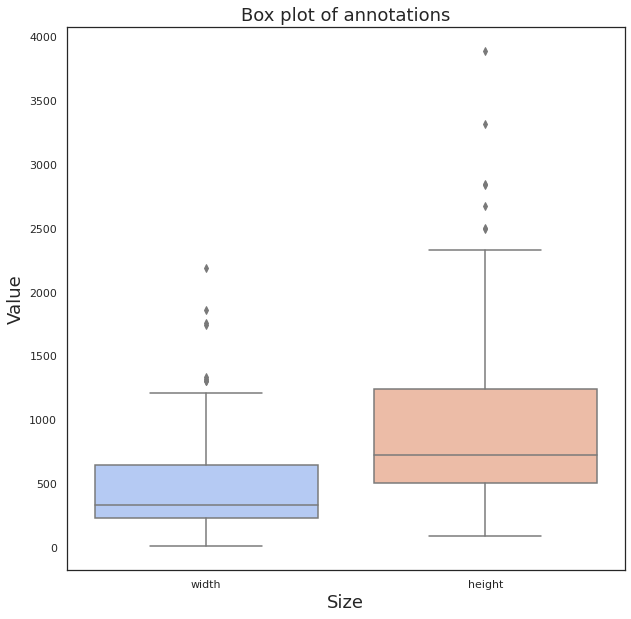

In [ ]:
box_plot = sns.boxplot(data=annotations_df[['width', 'height']], palette='coolwarm')
box_plot.set_title("Box plot of annotations", fontsize=18)
box_plot.set_xlabel("Size", fontsize=18)
box_plot.set_ylabel("Value", fontsize=18)
fig = box_plot.get_figure()
fig.set_size_inches((10, 10))
fig.savefig('/content/repo/assets/box_plot_annotations.png', dpi=200)

## 2. Model Development

For this, we are based on this Darknet tutorial: https://colab.research.google.com/drive/1Mh2HP_Mfxoao6qNFbhfV3u28tG8jAVGk
and the [original repository](https://github.com/AlexeyAB/darknet).

For this project we have used **Yolo version 3**. Also, we only use the tiny version using already trained weights with the COCO dataset. This file can be downloaded [here](https://drive.google.com/file/d/18v36esoXCh-PsOKwyP2GWrpYDptDY8Zf/view). However it is not necessary to download as in our repository we have already put it there. 


### 2.1 Setup Darknet

**Clone Darknet repository**

In [6]:
# Clone darknet repo
%cd /content/
!git clone https://github.com/AlexeyAB/darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 13939, done.
remote: Total 13939 (delta 0), reused 0 (delta 0), pack-reused 13939
Receiving objects: 100% (13939/13939), 12.42 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (9526/9526), done.


**Configure to use GPU and OPENCV**.

In case to have access to a GPU, do no run this cell. However the training process will be quite slow.

In [7]:
# change makefile to have GPU and OPENCV enabled
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [8]:
# verify CUDA (=10.1)
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


**Build darknet**: This builds the files to execute darknet

In [9]:
# Build Darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

### 2.2 Setup google drive (Optional)

As per the process of developing the model, we train several model (experiments) we generate some logs and backupds which are stored in a Google Drive shared drive. 

**We highly recommend to setup this as it will make things easiers**. Also, all the next steps are done using Google Drive as it runs in Google Colab.

In [10]:
%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Create a symbolic link to the `Shared drives` (You will probable have to change the folders of this symbolic link).

In [11]:
# This creates a symbolic link so that now the path /content/gdrive/Shared drives/ is equal to /content/shared_drive
!ln -s /content/gdrive/Shared\ drives/ /content/shared_drive
!ls shared_drive/

Inteligentes


### 2.3. Train the Custom Object Detector

To start training there are some configuration files that are already in the repository in `/content/repo/darknet_conf/`.
To train your model you will have to change these files: 

*   /content/repo/darknet_conf/yolov3-tiny.cfg: This file contains the initial configuration for the network. This already has the best found configurations. Check the [documentation](https://github.com/AlexeyAB/darknet) to see how to modify it. 
*   /content/repo/darknet_conf/obj.data: File with the configurations necessary to run the darknet commands. **Yo might have to modify it for every training**.
*   /content/repo/model_data/train.txt and val.txt are automatically generated files in the section 1 when the dataset is split.

#### 2.3.1. Update configurations and hyperparameters

To start training there are some configuration files that are already in the repository in `/content/repo/darknet_conf/`.
To train your model you will have to change these files: 

*   /content/repo/darknet_conf/yolov3-tiny.cfg: This file contains the initial configuration for the network. This already has the best found configurations. Check the [documentation](https://github.com/AlexeyAB/darknet) to see how to modify it. 
*   /content/repo/darknet_conf/obj.data: File with the configurations necessary to run the darknet commands. **Yo might have to modify it for every training, and specifically the backup field**.
*   /content/repo/model_data/train.txt and val.txt are automatically generated files in the section 1 when the dataset is split.

In general, the hyperparameters to find were image width and height.

#### 2.3.2. Anchors generation

In order to update the anchors for specific dimensions, a KMeans algorithm is accomplished as follows. Here we generate 6 clusters or anchors that generalizes the different boxes used for training.

In the image below we can see how these clusters are generated.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils import scale_anchors, plot_cluster_predictions

def generate_anchors(n_anchors, width, height):
  boxes = np.array([[w,h] for image in train_data for _, _, w, h in annotations[image]])
  kmeans = KMeans(n_anchors)
  y = kmeans.fit_predict(boxes)
  result = sorted(scale_anchors(kmeans.cluster_centers_, width, height).tolist())
  print('The generated anchors are:')
  for w, h in result:
    print(f'{w}, {h}', end=',   ')
  plot_cluster_predictions(kmeans, boxes, y, n_clusters=n_anchors,cmap=plt.cm.hsv, title_str=f"Anchors distribution with {n_anchors} anchors")

The generated anchors are:
42, 62,   78, 100,   127, 180,   190, 260,   287, 321,   300, 492,   

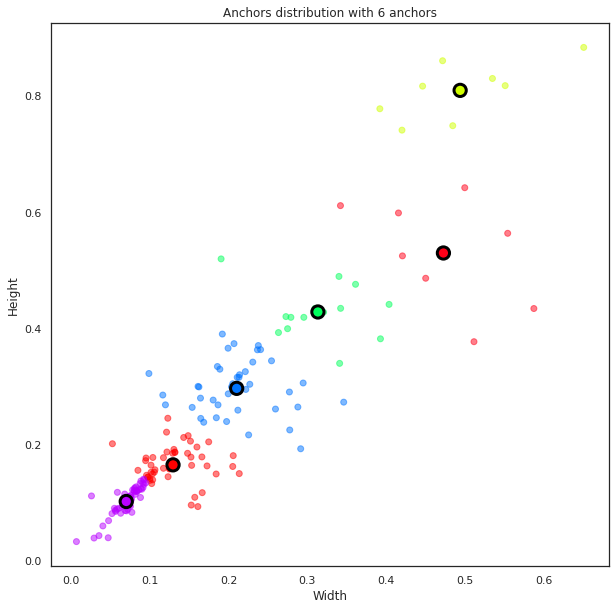

In [ ]:
generate_anchors(n_anchors=6, width=608, height=608)

#### 2.3.3. Do train the model

To start run the following cells.

**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. If you are using Google Colab you can put the next code in the browser console to avoid Google Colab turning off the instance after some time.

```js
function ClickConnect(){
  console.log("Working"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();

}
setInterval(ClickConnect,60000)
```

When you run this command, it generates logs file, modify this path in case you want to store this file in other directory.

In [ ]:
# Train tiny net
obj_data_path = '/content/repo/darknet_conf/obj.data'
cfg_path = '/content/repo/darknet_conf/yolov3-tiny.cfg'
def train_model(weights_path, logs_path):
  !./darknet detector train $obj_data_path $cfg_path $weights_path -dont_show -map >> $logs_path

/content/darknet


In [ ]:
%cd /content/darknet
weights_path = '/content/repo/darknet_conf/yolov3-tiny.conv.11'
# weights_path = '/content/shared_drive/Inteligentes/darknet_backup/exp9/yolov3-tiny_last.weights'
logs_path = '/content/shared_drive/Inteligentes/darknet_logs/exp9/loss_tiny.txt'
train_model(weights_path, logs_path)

When training is done, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2. Also, it add the **mAP** metric to tell how accurate is your model in the validation set.

In [ ]:
from utils import imShow
imShow('chart.png')
!cp chart.png /content/shared_drive/Inteligentes/darknet_backup/exp9/

## 3. Evaluate experiments and look for best model

Here we do all necessary steps to get metrics and evaluate the different experiments

#### Description of diferent experiments

As per the previous phase, training, we have trained several models looking for good hyperparameters for the model.

| Experiment | Description hyperpameter                |
|------------|-----------------------------------------|
| 2          | IOU threshold of 0.6                    |
| 3          | IOU threshold of 0.8                    |
| 4          | Image size of 416x416 (Initial dataset) |
| 5          | Image size of 608x608 (Initial dataset) |
| 6          | Image size of 960x960 (Initial dataset) |
| 7          | Image size of 608x608 with anchors updated (Initial dataset)      |
| 8          | Image size of 832x832 with anchors updated (Initial dataset)      |
| 9          | Image size of 960x960 + Negative images |
| 10         | Image size of 608x608 + Corrected annotations |
| 11         | Image size of 608x608 + Negative images |
| 12         | Image size of 608x608 + Aditional + Augmentation on some difficult images |
| 13         | Image size of 608x608 + Negative images + Aditional + Augmentation on some difficult images |


### 3.1 Plot training loss and validation mAP

Here the log files are parsed for every experiment

#### 3.1.0. Parse logs to generate plots


In [36]:
from utils import parse_logs
losses, maps = parse_logs(ignore_logs_from=['.ipynb_checkpoints'])

Loading logs from exp2.
Loading logs from exp4.
Loading logs from exp3.
Loading logs from exp5.
	Expected 343 but got 345
Loading logs from exp6.
	Expected 751 but got 906
Loading logs from exp7.
	Expected 830 but got 846
Loading logs from exp8.
Loading logs from exp9.
	Expected 236 but got 237
	Expected 727 but got 728
Loading logs from exp11.
Loading logs from exp10.
Loading logs from exp12.
	Expected 1243 but got 1244
	Expected 1554 but got 1556
Loading logs from exp13.


In [248]:
import plotly.graph_objects as go

def plot_experiments_loss(losses):
  fig = go.Figure()
  for key, value in losses.items():
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(value) + 1)),
            y=value,
            text=f'Loss {key}',
            name=f'Loss {key}'
        )
      )
  fig.update_layout(
      title='Loss for each experiment',
      xaxis_title="Epochs",
      yaxis_title="Loss",
      font=dict(
          size=18,
          color="#7f7f7f"
      )
  )
  fig.show()

def plot_experiments_AP(data):
  fig = go.Figure()
  for key, value in data[0].items():
    fig.add_trace(
        go.Scatter(
            x=data[1][key],
            y=data[0][key],
            text=f'AP {key}',
            name=f'AP {key}',
            mode="lines+markers"
        )
      )
  fig.update_layout(
      title='Average Precison (AP) for each experiment',
      xaxis_title="Epochs",
      yaxis_title="Average Precison (AP) (%)",      
      font=dict(
          size=18,
          color="#7f7f7f"
      )
  )
  fig.show()

#### 3.1.1. Plot of loss in different experiments


In [38]:
plot_experiments_loss(losses)

#### 3.1.2. Plot of Average Precision (AP) for each experiment

In [249]:
plot_experiments_AP(maps)

### 3.2 Generate metrics of experiments

Here we use some of the executed experiments and its stored weights to generate metrics like Recall, Precision and AP.

For that, we use the [Object-Detection-Metrics repository](https://github.com/rafaelpadilla/Object-Detection-Metrics.git), which contains code that will help us to calculate the mentioned metrics.

For every experiment, we calculate the metrics for training, validation and testing sets.

#### 3.2.0. Utilities

In [202]:
from utils import convert_x_y_to_top_left, resize_annotation, read_json

_GROUND_TRUTH_PATH = '/content/shared_drive/Inteligentes/darknet_backup'
_DETECTIONS_TRUTH_PATH = '/content/shared_drive/Inteligentes/darknet_backup'
_METRICS_PATH = '/content/shared_drive/Inteligentes/metrics_graphs'
_WEIGHTS_PATH ='/content/shared_drive/Inteligentes/darknet_backup'

def create_ground_truth_for_metrics(dataset, name_dataset, experiment, annotations):
  '''
  This generates ground truth files as requested in the documentation 
  in https://github.com/rafaelpadilla/Object-Detection-Metrics.git
  '''
  print(f"Generating ground truth files for {name_dataset} set on {experiment}\n\n")

  for image in dataset:
    image_name = image.split("/")[-1].split(".")[0]
    boxes = annotations[image]
    new_file_path = f'{_GROUND_TRUTH_PATH}/{experiment}/{name_dataset}/groundtruths/{image_name}.txt'
    print(f"Creating... {new_file_path}")
    with open(new_file_path, "w") as groudtruth:
      for box in boxes:
        x, y, width, height = box
        x, y, width, height = resize_annotation(image, x, y, width, height)
        top, left = convert_x_y_to_top_left(image, x, y, width, height)
        groudtruth.write(f"QR {left} {top} {width} {height}\n")

def create_detections_for_metrics(content, name_dataset, experiment):
  '''
  This generates detection files as requested in the documentation 
  in https://github.com/rafaelpadilla/Object-Detection-Metrics.git
  '''
  print(f"Generating detection files for {name_dataset} set on {experiment}\n\n")

  for image in content:
    image_name = image["filename"].split("/")[-1].split(".")[0]
    detections_path = f'{_DETECTIONS_TRUTH_PATH}/{experiment}/{name_dataset}/detections/{image_name}.txt'
    print(f"Creating... {detections_path}")
    with open(detections_path, "w") as detection:
      for boxes in image["objects"]:
        confidence = boxes["confidence"]
        coordinates = boxes["relative_coordinates"]
        x = coordinates["center_x"]
        y = coordinates["center_y"]
        width = coordinates["width"]
        height = coordinates["height"]

        x, y, width, height = resize_annotation(image["filename"], x, y, width, height)
        top, left = convert_x_y_to_top_left(image["filename"], x, y, width, height)
        detection.write(f"QR {confidence} {left} {top} {width} {height}\n")

# Generate results file
def generate_json(experiment,  split_set_path="/content/repo/model_data/train.txt", used_weights = 2, thresh=0.5):
  print("*"*100)
  print(f"Generating json with metrics for {split_set_path} set on experiment: {experiment}")
  %cd /content/darknet
  if used_weights == 1: weights = "yolov3-tiny_best.weights"
  elif used_weights == 2: weights = "yolov3-tiny_final.weights"
  elif used_weights == 3: weights = "yolov3-tiny_1000.weights"
  elif used_weights == 4: weights = "yolov3-tiny_2000.weights"
  elif used_weights == 5: weights = "yolov3-tiny_last.weights"

  weights_tiny_path = f'{_WEIGHTS_PATH}/{experiment}/{weights}'
  obj_data_path = '/content/repo/darknet_conf/obj.data'
  cfg_path = '/content/repo/darknet_conf/yolov3-tiny.cfg'
  json_file_path = '/content/result_test.json'
  !./darknet detector test $obj_data_path $cfg_path $weights_tiny_path -ext_output -dont_show -out $json_file_path < $split_set_path
  return read_json(json_file_path)

def generate_results_for_metrics(experiment, dataset_name):
  print(f"Getting metrics for: {experiment}")
  ground_truths_path = f'{_GROUND_TRUTH_PATH}/{experiment}/{dataset_name}/groundtruths'
  detections_path = f'{_DETECTIONS_TRUTH_PATH}/{experiment}/{dataset_name}/detections'
  results_path = f'{_METRICS_PATH}/new_experiments'
  !python /content/Object-Detection-Metrics/pascalvoc.py -gt $ground_truths_path -det $detections_path -gtformat xywh -detformat xywh -sp $results_path
  
  results_name = f"results_{dataset_name}_{experiment}.txt"
  graph_name = f"QR_{dataset_name}_{experiment}.png"
  !mv $_METRICS_PATH/new_experiments/results.txt $_METRICS_PATH/$results_name
  !mv $_METRICS_PATH/new_experiments/QR.png $_METRICS_PATH/$graph_name

def make_metrics_dirs(experiment, dataset_name):
  !rm -r $_GROUND_TRUTH_PATH/$experiment/$dataset_name
  !mkdir $_GROUND_TRUTH_PATH/$experiment
  !mkdir $_METRICS_PATH/new_experiments
  !mkdir $_GROUND_TRUTH_PATH/$experiment/$dataset_name
  !mkdir $_GROUND_TRUTH_PATH/$experiment/$dataset_name/groundtruths
  !mkdir $_GROUND_TRUTH_PATH/$experiment/$dataset_name/detections

#### 3.2.1 Change .cfg file

As every experiment might have differnt configurations in the *.cfg* file,before generating the metrics you must update this file with the anchors used to train that model.

The width and height are recommended to be grater than the used to train.
Also, for testing, the batch and subdivisions must be changes to 1.

Run next cells

In [20]:
# Need to set our custom cfg to test mode 
%cd /content/
!sed -i 's/batch=64/batch=1/' repo/darknet_conf/yolov3-tiny.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' repo/darknet_conf/yolov3-tiny.cfg

/content


In [21]:
# Change to .txt files to edit them in colab
# Use this function when you want to update the configuration files
def config_files_2_txt():
  !mv /content/repo/darknet_conf/obj.data /content/repo/darknet_conf/obj_data.txt
  !mv /content/repo/darknet_conf/yolov3-tiny.cfg /content/repo/darknet_conf/yolov3-tiny.txt

# Rename to original file extension
# When you are done with the edition of configuration files. Run this to change extension.
def config_files_2_original_extension():
  !mv /content/repo/darknet_conf/obj_data.txt /content/repo/darknet_conf/obj.data
  !mv /content/repo/darknet_conf/yolov3-tiny.txt /content/repo/darknet_conf/yolov3-tiny.cfg

#### 3.2.2. Clone metrics repository



In [22]:
%cd /content/
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

/content
Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 491 (delta 9), reused 1 (delta 0), pack-reused 473
Receiving objects: 100% (491/491), 10.60 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (213/213), done.


#### 3.2.3. Generate metrics (Recall and precision)

Here we only generated metrics for three experiments 9, 10, 11 as they look quite promising to have good results in a testing set.

In [135]:
import time
def generate_metrics_for_dataset(current_experiment, dataset, annotations, metrics_name='training', dataset_path="/content/repo/model_data/train.txt"):
  make_metrics_dirs(current_experiment, metrics_name)

  create_ground_truth_for_metrics(dataset, metrics_name, experiment=current_experiment, annotations=annotations)

  start_time = time.time()

  content = generate_json(experiment=current_experiment, split_set_path=dataset_path)
  create_detections_for_metrics(content, name_dataset=metrics_name, experiment=current_experiment)

  print("--- It took %s seconds to predict ---" % (time.time() - start_time))
  generate_results_for_metrics(current_experiment, metrics_name)

In [64]:
config_files_2_txt()

In [65]:
config_files_2_original_extension()

In [ ]:
_GROUND_TRUTH_PATH = '/content/shared_drive/Inteligentes/darknet_backup'
_DETECTIONS_TRUTH_PATH = '/content/shared_drive/Inteligentes/darknet_backup'
_METRICS_PATH = '/content/shared_drive/Inteligentes/metrics_graphs'
_WEIGHTS_PATH ='/content/shared_drive/Inteligentes/darknet_backup'

experiment = 'exp10'
generate_metrics_for_dataset(experiment, train_data, annotations, 'training', "/content/repo/model_data/train.txt")
generate_metrics_for_dataset(experiment, val_data, annotations, 'validation', "/content/repo/model_data/val.txt")
generate_metrics_for_dataset(experiment, test_data, annotations, 'testing', "/content/repo/model_data/test.txt")

#### 3.2.4. Plot metrics

As in the logs results, we decide to only get metrics from three models.

In [147]:
def plot_precision_recall(precision, recall, avg_precisions, title):
  fig = go.Figure()
  for k, v in precision.items():
    fig.add_trace(
        go.Scatter(
            x=recall[k],
            y=precision[k],
            text=f'{k}',
            name=f'{k} - AP {avg_precisions[k]}%',
        )
      )
  fig.update_layout(
      title=title,
      xaxis_title="Recall",
      yaxis_title="Precision",
      font=dict(
          size=18,
          color="#7f7f7f"
      )
  )
  fig.show()

##### Plot Precision x Recall for training set

In [205]:
from utils import get_experiments_metrics

_METRICS_PATH = '/content/shared_drive/Inteligentes/metrics_graphs'
train_precision, train_recall, train_aps = get_experiments_metrics('training', _METRICS_PATH)
plot_precision_recall(train_precision, train_recall, train_aps, 'Precision x Recall each experiment on training set.')

##### Plot Precision x Recall for validation set

In [206]:
_METRICS_PATH = '/content/shared_drive/Inteligentes/metrics_graphs'
val_precision, val_recall, val_aps = get_experiments_metrics('validation', _METRICS_PATH)
plot_precision_recall(val_precision, val_recall, val_aps, 'Precision x Recall each experiment on validation set.')

##### Plot Precision x Recall for testing set


In [207]:
_METRICS_PATH = '/content/shared_drive/Inteligentes/metrics_graphs'
test_precision, test_recall, test_aps = get_experiments_metrics('testing', _METRICS_PATH)
plot_precision_recall(test_precision, test_recall, test_aps, 'Precision x Recall each experiment on testing set.')

#### **Evaluation Conclusions**

As per the images, we decide to select the **experiment 10** as it appears to have good results in testing and Average Precision in this experiment is not that high telling us that is not overfitting too much.

## 4. Test final model with aditional test set

As per the project, an additional test set is given, here are the results generated using the best model. 

For our case we have chosen the model 10.

These weights are alredy in our repository. To replicate, use these weights and modify the configuration (.cfg) file with a width and height of **832** to have a better prediction.

### 4.0. Utils to create the result predictions as a Dataframe.

In [215]:
def generate_testing_file(output_path):
  files = !ls /content/test/*.{jpg,JPG} -w 1
  files = list(sorted(files))
  with open(output_path, 'w') as test_file:
    for f in files:
      test_file.write(f'{f}\n')
  return files

def generate_df_from_json_results(results):
  data = []
  for result in results:
    filename = result['filename']
    pred_boxes = result['objects']
    if not len(pred_boxes):
      data.append([filename, 0, 0, 0, 0, 0])
      continue
    for box in pred_boxes:
      coordinates = box['relative_coordinates']
      conf, x, y, w, h = box['confidence']*100, coordinates['center_x'], coordinates['center_y'], coordinates['width'], coordinates['height']
      x, y, w, h = map(int, resize_annotation(filename, x, y, w, h))
      x, y = convert_x_y_to_top_left(None, x, y, w, h)
      data.append([filename, conf, x, y, w, h])
  return pd.DataFrame(data, columns=['filename', 'confidence', 'left_x', 'top_y', 'width', 'height'])

def load_test_annotations():
  files = !ls /content/test/*.txt -w 1
  files = list(sorted(files))
  images = !ls /content/test/*.{jpg,JPG} -w 1
  print(len(images))
  images = list(sorted(images))
  data = {}
  total_boxes = 0
  for txt_file, image in zip(files, images):
    data[image] = []
    with open(txt_file, 'r') as f:
      boxes = f.readlines()
      for box in boxes:
          _, x, y, w, h = map(float, box.strip().split(' '))
          total_boxes += 1
          data[image].append((x,y,w,h))
  print(f'Loaded {len(images)} imgs and {total_boxes} boxes')
  return data

def generate_predictions(weights_path, dataset_path="contet/test_dataset.txt"):
  %cd /content/darknet
  obj_data_path = '/content/repo/darknet_conf/obj.data'
  cfg_path = '/content/repo/darknet_conf/yolov3-tiny.cfg'
  json_file_path = '/content/result_test.json'
  !./darknet detector test $obj_data_path $cfg_path $weights_path -ext_output -dont_show -out $json_file_path < $dataset_path
  return read_json(json_file_path)

### 4.1. Upload testing folder with images and update configuration file

To update the .cfg file in `/content/repo/darknet_conf/yolov3-tiny.cfg` with a width and height of 832.

The images must be stored in: `/content/test`

### 4.2. Generate predictions and dataframe

In [ ]:
dataset_path = '/content/final_test.txt'
generate_testing_file(dataset_path)
results = generate_predictions('/content/repo/darknet_conf/trained_QR.weights', dataset_path=dataset_path)
results_df = generate_df_from_json_results(results)

In [220]:
results_df

,filename,confidence,left_x,top_y,width,height
0,/content/test/20110817_043.jpg,38.6727,460,447,589,1727
1,/content/test/20110817_143.jpg,0.0000,0,0,0,0
2,/content/test/20110817_207.jpg,0.0000,0,0,0,0
3,/content/test/20110817_394.jpg,92.7863,1177,613,157,555
4,/content/test/20110817_402.jpg,99.5486,882,592,192,724
5,/content/test/IMG_20120226_153733.jpg,79.7640,307,631,330,809
6,/content/test/IMG_20120226_153733.jpg,78.8178,1158,550,59,201
7,/content/test/IMG_20120226_164408.jpg,99.9367,1027,273,142,345
8,/content/test/IMG_20120226_164408.jpg,99.5219,1079,591,68,191
9,/content/test/IMG_20120226_164408.jpg,98.5105,566,764,77,353


In [240]:
results_df[['filename', 'left_x',	'top_y',	'width',	'height']].to_csv('/content/additional_test_results.csv', index=False)

### 4.3 Show the prediction of one image (Optional)

For that, change the name of the image you want to show and ti will rendered in `predictions.jpg`.

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    832 x 832 x   3 ->  832 x 832 x  16 0.598 BF
   1 max                2x 2/ 2    832 x 832 x  16 ->  416 x 416 x  16 0.011 BF
   2 conv     32       3 x 3/ 1    416 x 416 x  16 ->  416 x 416 x  32 1.595 BF
   3 max                2x 2/ 2    416 x 416 x  32 ->  208 x 208 x  32 0.006 BF
   4 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   5 max                2x 2/ 2    208 x 208 x  64 ->  104 x 104 x  64 0.003 BF
   6 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   7 max                2x 2/ 2    104 x 104 x 128 ->   52 x  52 x 128 0.001 BF
   8 conv    256       3 x 3/ 1     52 

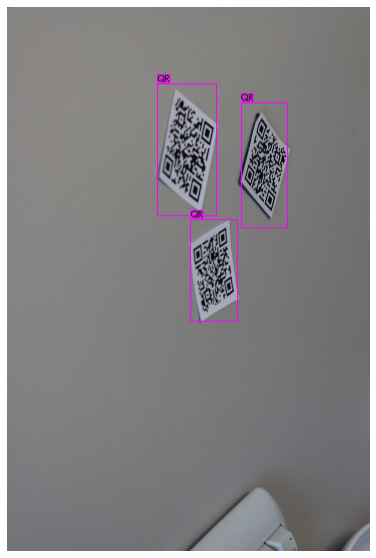

In [224]:
from utils import imShow
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet
weights_path = '/content/repo/darknet_conf/trained_QR.weights'
img_path = '/content/test/IMG_2758.JPG'
!./darknet detector test /content/repo/darknet_conf/obj.data /content/repo/darknet_conf/yolov3-tiny.cfg $weights_path $img_path -thresh 0.3 -dont_show
imShow('predictions.jpg')